# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/10ZeNA14w4lhVM40Yv3sXqwFcV_7oLS_1?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:01<00:00, 105791520.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

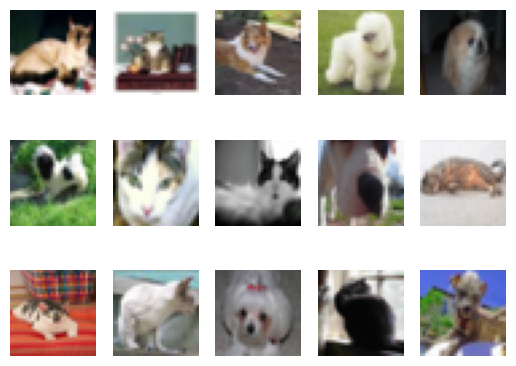

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [6]:
print("Training examples:", len(train_loader.dataset))
print("Validation examples:", len(val_loader.dataset))
print("Test examples:", len(test_loader.dataset))

Training examples: 50000
Validation examples: 50000
Test examples: 10000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [7]:
# A validation set is needed to test the model on unseen data, helping to avoid
# overfitting by ensuring the model doesn't just memorize the training data but
# learns to generalize. We would also need something to track validation
# accuracy in the training curve.

# Judging a model only by its performance on the training set can mislead you
# into thinking it's better than it actually is, as it may not perform well on
# new, unseen data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [8]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [27]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [12]:
for param in small_net.parameters():
    print(param.shape)
# The total number of parameters in small_net is:
# (5*3*3*3)+(5)+(1*245)+(1)=386

for param in large_net.parameters():
    print(param.shape)
# The total number of parameters in large_net is:
# (5*3*5*5)+(5)+(10*5*5*5)+(10)+(32*250)+(32)+(1*32)+(1)=9705

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [14]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [15]:
# batch_size = 64
# learning_rate = 0.01
# num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [48]:
small_net = SmallNet()
train_net(small_net, num_epochs=5)

# Files written to disk

# model_small_bs64_lr0.01_epoch0: checkpoint after epoch 0
# model_small_bs64_lr0.01_epoch1: checkpoint after epoch 1
# model_small_bs64_lr0.01_epoch2: checkpoint after epoch 2
# model_small_bs64_lr0.01_epoch3: checkpoint after epoch 3
# model_small_bs64_lr0.01_epoch4: checkpoint after epoch 4

# model_small_bs64_lr0.01_epoch4_train_err.csv: file containing training error
# model_small_bs64_lr0.01_epoch4_train_loss.csv: file containing training loss
# model_small_bs64_lr0.01_epoch4_val_err.csv: file containing validation error
# model_small_bs64_lr0.01_epoch4_val_loss.csv: file containing validation loss

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43275, Train loss: 0.6750623955726623 |Validation err: 0.381, Validation loss: 0.6581626161932945
Epoch 2: Train err: 0.371875, Train loss: 0.6496369152069091 |Validation err: 0.384, Validation loss: 0.6638244986534119
Epoch 3: Train err: 0.35025, Train loss: 0.6355056324005127 |Validation err: 0.353, Validation loss: 0.6260157078504562
Epoch 4: Train err: 0.339375, Train loss: 0.6214285769462585 |Validation err: 0.354, Validation loss: 0.624940775334835
Epoch 5: Train err: 0.334125, Train loss: 0.6118814716339112 |Validation err: 0.3265, Validation loss: 0.6122822929173708
Finished Training
Total time elapsed: 15.39 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [18]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [31]:
train_net(small_net) # Total time elapsed: 87.89 seconds
train_net(large_net) # Total time elapsed: 97.51 seconds

# large_net took longer to train because it has more parameters

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.32075, Train loss: 0.6001654999256134 |Validation err: 0.3375, Validation loss: 0.6160770282149315
Epoch 2: Train err: 0.315375, Train loss: 0.5937726888656616 |Validation err: 0.3385, Validation loss: 0.6340117994695902
Epoch 3: Train err: 0.30825, Train loss: 0.5896465487480164 |Validation err: 0.314, Validation loss: 0.606388745829463
Epoch 4: Train err: 0.311375, Train loss: 0.5856761095523835 |Validation err: 0.328, Validation loss: 0.6113690435886383
Epoch 5: Train err: 0.30225, Train loss: 0.5831401715278626 |Validation err: 0.308, Validation loss: 0.6056779511272907
Epoch 6: Train err: 0.302875, Train loss: 0.5780168986320495 |Validation err: 0.3105, Validation loss: 0.6076986379921436
Epoch 7: Train err: 0.3015, Train loss: 0.5758937051296235 |Validation err: 0.323, Validation loss: 0.6030783243477345
Epoch 8: Train err: 0.301875, Train loss: 0.5725233724117279 |Validation err: 0.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Training curve: small_net


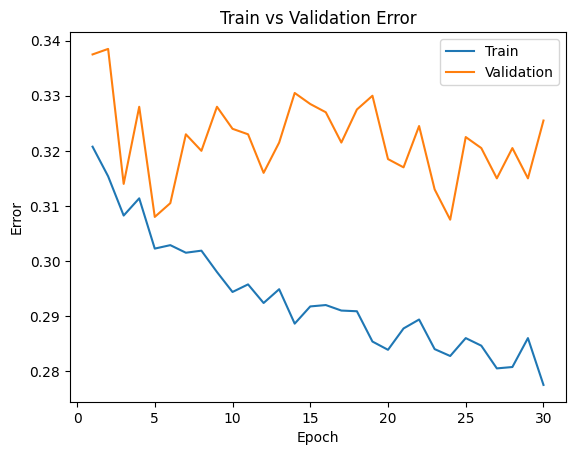

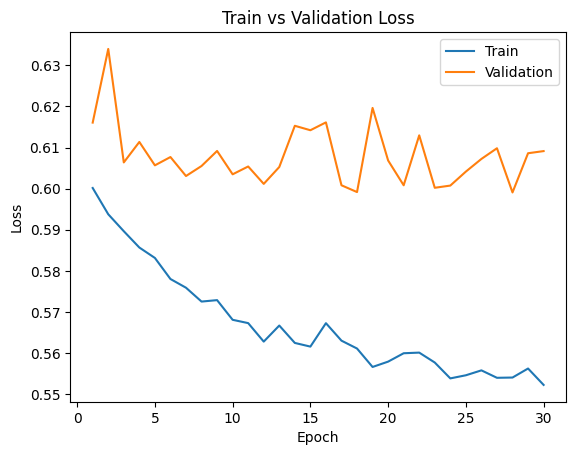

Training curve: large_net


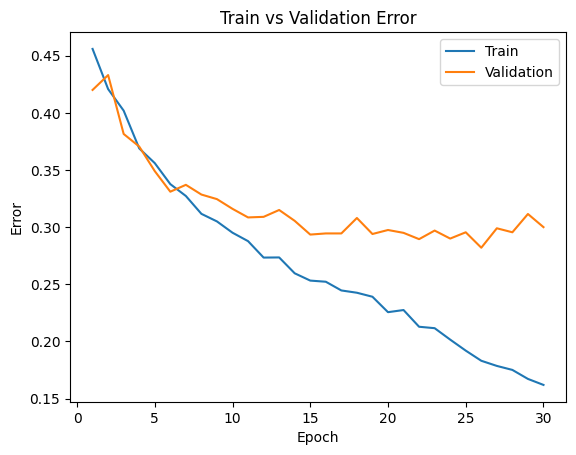

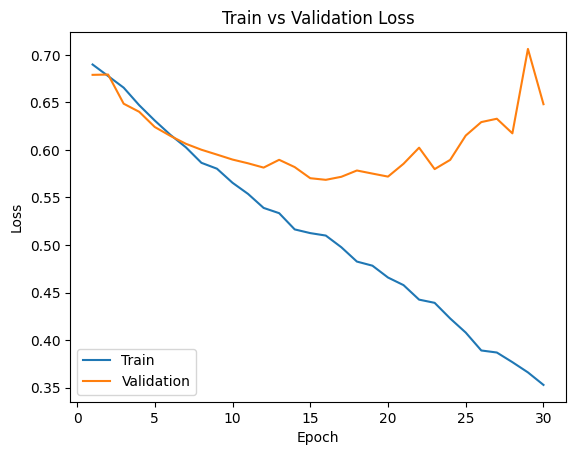

In [32]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)

print("Training curve: small_net")
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)
print("Training curve: large_net")
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# For small_net, the model shows underfitting near the beginning of the curves
# for both validation error and loss graphs. The train and validation curves are
# also qutie far apart.

# For large_net, the model shows underfitting near the beginning and it
# eventually leads to overfitting near the end. The training error and loss
# continues decreasing as epoch increases, but validation error and loss slowly
# stops decreasing around the half-way point.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360028266907 |Validation err: 0.467, Validation loss: 0.6924686599522829
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493307799101
Epoch 3: Train err: 0.43575, Train loss: 0.6916067419052124 |Validation err: 0.4285, Validation loss: 0.6908544395118952
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.6896596923470497
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.6886942777782679
Epoch 6: Train err: 0.435875, Train loss: 0.6887419753074646 |Validation err: 0.4195, Validation loss: 0.6867837514728308
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267921447754 |Validation er

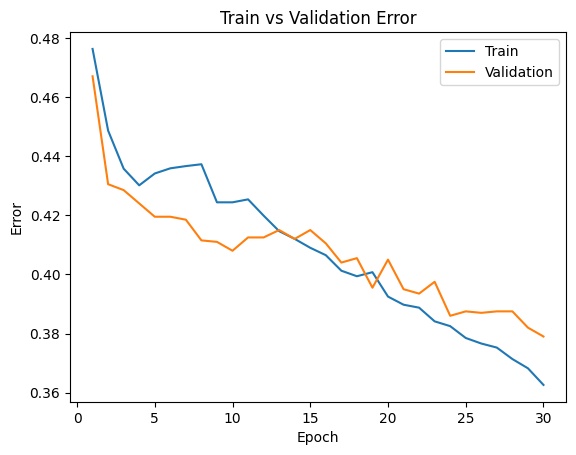

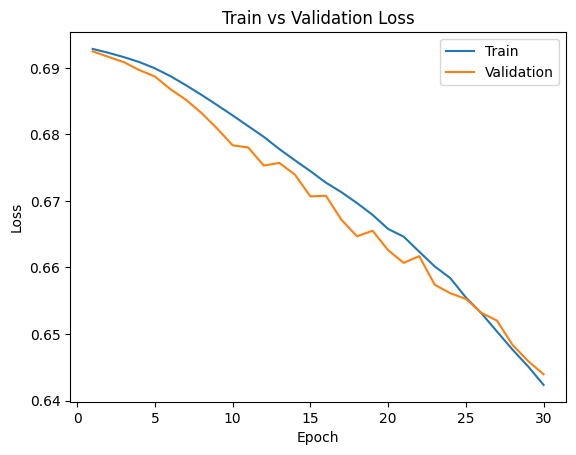

In [33]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

# Total time elapsed: 94.83 seconds
# The model takes approximately the same to train.
# Lowering the learning rate does not significantly change the training time but
# results in higher error and loss on the training data. For validation data,
# while the error is higher, the lower learning rate helps avoid overfitting,
# indicating that 0.001 may be too slow for efficient training in this case.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743808498382569 |Validation err: 0.3565, Validation loss: 0.6350402869284153
Epoch 2: Train err: 0.364375, Train loss: 0.6394594783782959 |Validation err: 0.364, Validation loss: 0.6380155384540558
Epoch 3: Train err: 0.357125, Train loss: 0.6292509632110596 |Validation err: 0.357, Validation loss: 0.6313505992293358
Epoch 4: Train err: 0.351375, Train loss: 0.6222558770179748 |Validation err: 0.3615, Validation loss: 0.6581139843910933
Epoch 5: Train err: 0.3425, Train loss: 0.6109966540336609 |Validation err: 0.327, Validation loss: 0.593532383441925
Epoch 6: Train err: 0.31975, Train loss: 0.5888414912223816 |Validation err: 0.3045, Validation loss: 0.6088876193389297
Epoch 7: Train err: 0.31825, Train loss: 0.5887727000713349 |Validation err: 0.3255, Validation loss: 0.6114899981766939
Epoch 8: Train err: 0.310125, Train loss: 0.5762689855098725 |Validation err: 0.

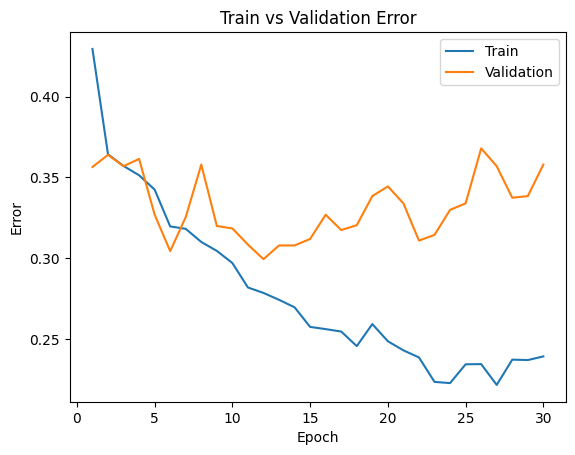

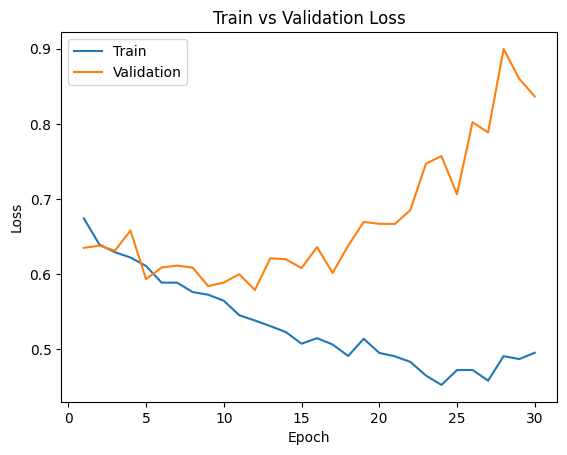

In [34]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)

# Total time elapsed: 94.88 seconds
# The model takes approximately the same to train.
# Increasing the learning rate does not significantly change the training time
# but results in slightly higher error and loss on the training data. For
# validation data, it increases around the half-way point indicated overfitting.
# This indicates that 0.1 may be too fast.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379515349865 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870153188705
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883531995117664 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.411, Va

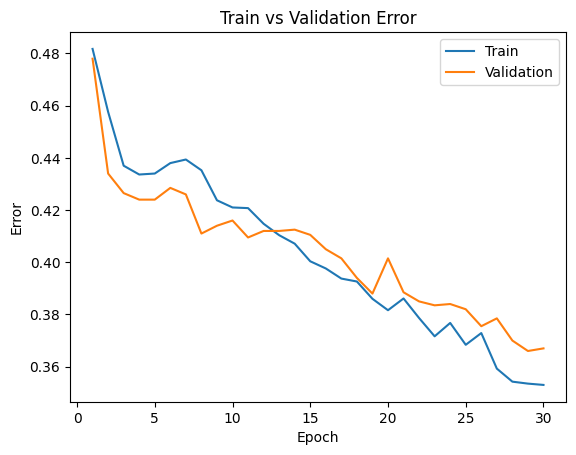

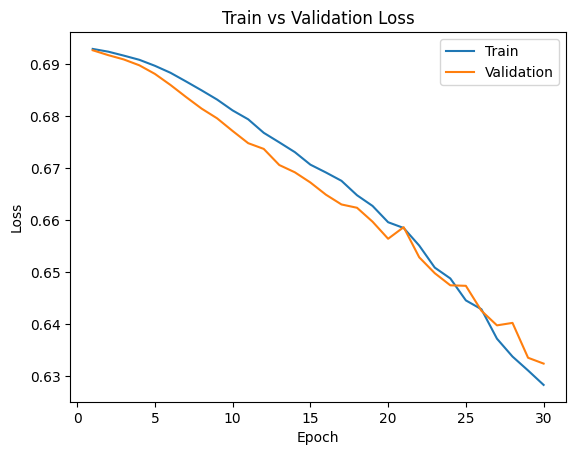

In [35]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# Total time elapsed: 82.25 seconds
# The model takes shorter time to train.
# The increase in batch size means the number of iterations within each epoch is
# smaller, reducing the training time. Increasing the batch size eliminated the
# signs of overfitting.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775506158471107 |Validation err: 0.378, Validation loss: 0.6512571625709533
Epoch 2: Train err: 0.3655, Train loss: 0.6395608481168747 |Validation err: 0.353, Validation loss: 0.6191524927616119
Epoch 3: Train err: 0.339875, Train loss: 0.6127814228534698 |Validation err: 0.3495, Validation loss: 0.6442944076061249
Epoch 4: Train err: 0.31475, Train loss: 0.5870258185863495 |Validation err: 0.3385, Validation loss: 0.5978640830516815
Epoch 5: Train err: 0.303, Train loss: 0.5651368154883385 |Validation err: 0.305, Validation loss: 0.5715659594535828
Epoch 6: Train err: 0.29025, Train loss: 0.5493593747615815 |Validation err: 0.302, Validation loss: 0.5801575357913971
Epoch 7: Train err: 0.26925, Train loss: 0.5272505192756652 |Validation err: 0.3005, Validation loss: 0.5818900580406189
Epoch 8: Train err: 0.254375, Train loss: 0.5104012369215488 |Validation err: 0.31

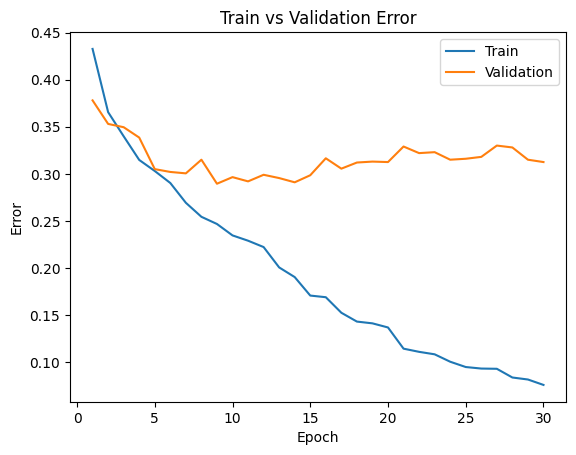

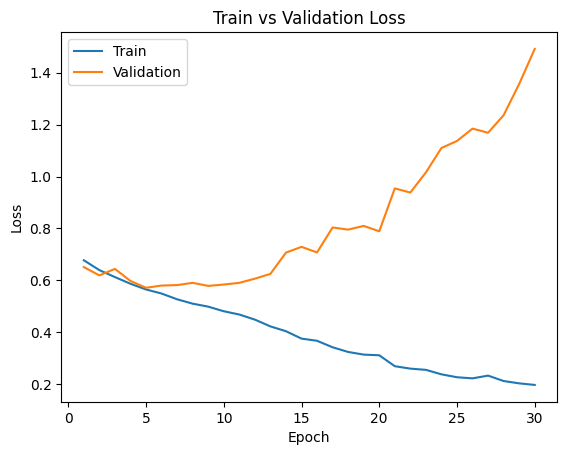

In [36]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# Total time elapsed: 133.49 seconds
# The model takes longer time to train.
# The decrease in batch size means the number of iterations within each epoch is
# larger, increasing the training time. The validation error and loss both show
# overfitting.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# Hyperparameters were chosen as:
  # network = large_net
  # batch_size = 256
  # learning_rate = 0.01
  # epoch = 30
# In the parts above, we saw that:
  # large_net works better than small_net
  # 0.01 was the better learning rate between 0.001, 0.01, and 0.1
  # Smaller batch_size resulted in overfitting, therefore having a larger
  # batch_size would result in better curves
  # The number of epochs was kept the same

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.467625, Train loss: 0.6926687732338905 |Validation err: 0.4355, Validation loss: 0.6918838396668434
Epoch 2: Train err: 0.45125, Train loss: 0.6913921386003494 |Validation err: 0.446, Validation loss: 0.689614325761795
Epoch 3: Train err: 0.428375, Train loss: 0.6892956364899874 |Validation err: 0.418, Validation loss: 0.6862076073884964
Epoch 4: Train err: 0.432375, Train loss: 0.6857246831059456 |Validation err: 0.4185, Validation loss: 0.6810905113816261
Epoch 5: Train err: 0.425875, Train loss: 0.6823424454778433 |Validation err: 0.414, Validation loss: 0.6773988157510757
Epoch 6: Train err: 0.41775, Train loss: 0.6785747222602367 |Validation err: 0.415, Validation loss: 0.6732195988297462
Epoch 7: Train err: 0.4085, Train loss: 0.674360191449523 |Validation err: 0.412, Validation loss: 0.669593334197998
Epoch 8: Train err: 0.401625, Train loss: 0.6709097884595394 |Validation err: 0.40

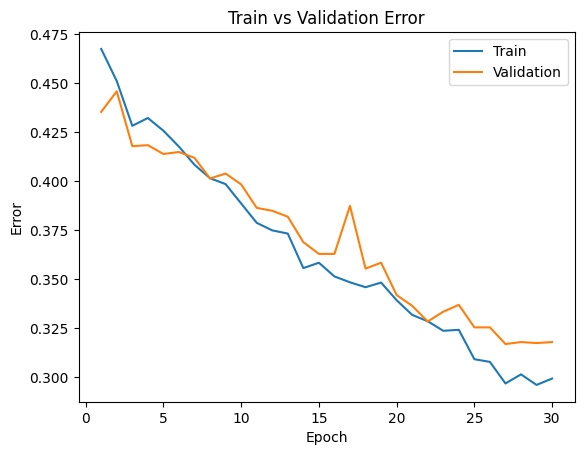

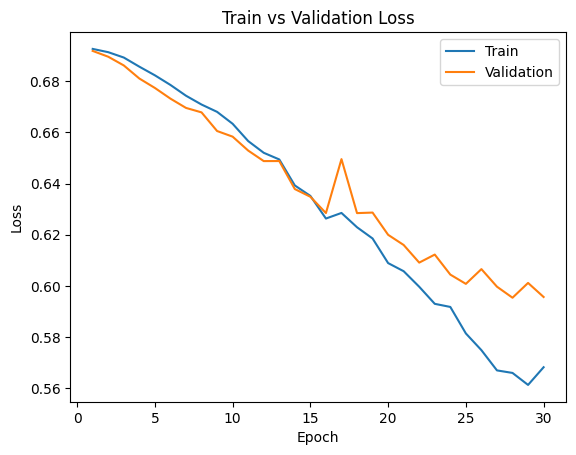

In [40]:
large_net = LargeNet()
train_net(large_net, 256, 0.01, 30)
model_path_large = get_model_name("large", batch_size=256, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
# Hyperparameters were chosen as:
  # network = large_net
  # batch_size = 256
  # learning_rate = 0.01
  # epoch = 25
# The results in Part(a) were good, but there was still slight overfitting near
# the end, starting from approximately epoch 21-22.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6955268159508705 |Validation err: 0.491, Validation loss: 0.6925421804189682
Epoch 2: Train err: 0.49775, Train loss: 0.6923610251396894 |Validation err: 0.4655, Validation loss: 0.6912638545036316
Epoch 3: Train err: 0.44675, Train loss: 0.6908448059111834 |Validation err: 0.4205, Validation loss: 0.6891277506947517
Epoch 4: Train err: 0.437, Train loss: 0.6882675737142563 |Validation err: 0.421, Validation loss: 0.6852065697312355
Epoch 5: Train err: 0.43725, Train loss: 0.6846398003399372 |Validation err: 0.4145, Validation loss: 0.6801528334617615
Epoch 6: Train err: 0.431, Train loss: 0.6808352507650852 |Validation err: 0.4145, Validation loss: 0.6756336018443108
Epoch 7: Train err: 0.421625, Train loss: 0.6762709021568298 |Validation err: 0.407, Validation loss: 0.6730251237750053
Epoch 8: Train err: 0.405625, Train loss: 0.6716891080141068 |Validation err: 0.402

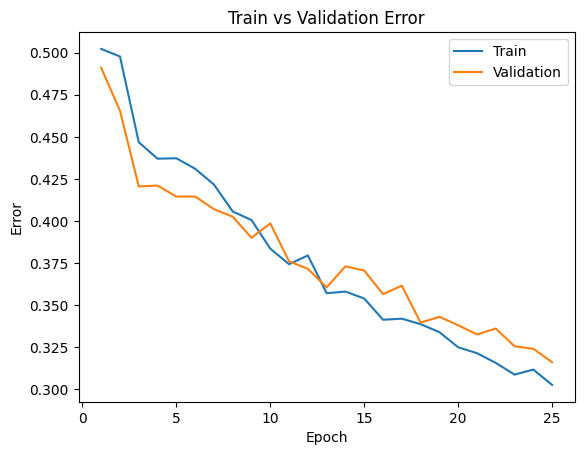

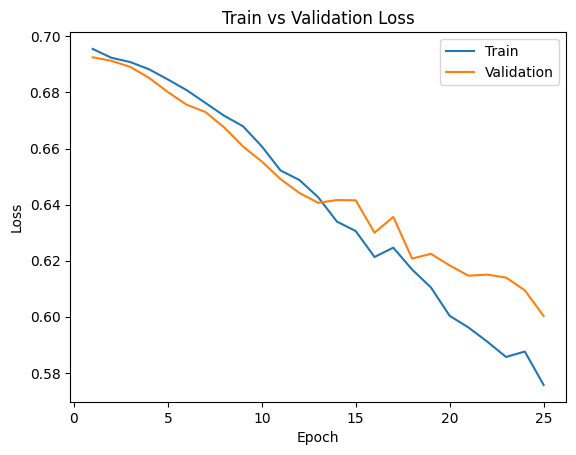

In [42]:
large_net = LargeNet()
train_net(large_net, 256, 0.01, 25)
model_path_large = get_model_name("large", batch_size=256, learning_rate=0.01, epoch=24)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [44]:
net = LargeNet()
train_net(net, 256, 0.01, 25)
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.01, epoch=24)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.497125, Train loss: 0.6934096086770296 |Validation err: 0.468, Validation loss: 0.6913570985198021
Epoch 2: Train err: 0.453125, Train loss: 0.6905003543943167 |Validation err: 0.44, Validation loss: 0.688907079398632
Epoch 3: Train err: 0.445875, Train loss: 0.6875452101230621 |Validation err: 0.434, Validation loss: 0.6848585233092308
Epoch 4: Train err: 0.43575, Train loss: 0.6822220403701067 |Validation err: 0.4335, Validation loss: 0.6786830052733421
Epoch 5: Train err: 0.431375, Train loss: 0.676894897595048 |Validation err: 0.417, Validation loss: 0.673255443572998
Epoch 6: Train err: 0.421375, Train loss: 0.6736960113048553 |Validation err: 0.405, Validation loss: 0.66932263225317
Epoch 7: Train err: 0.405, Train loss: 0.6672013718634844 |Validation err: 0.388, Validation loss: 0.6631332784891129
Epoch 8: Train err: 0.393875, Train loss: 0.6621953304857016 |Validation err: 0.3795, 

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# It resulted in a slightly smaller validation error and loss.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [45]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)

criterion = nn.BCEWithLogitsLoss()
test_error, test_loss = evaluate(net, test_loader, criterion)
print("Test classification error:", test_error, test_loss)

Files already downloaded and verified
Files already downloaded and verified
Test classification error: 0.3105 0.5830739140510559


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# The test classification error is marginally lower than the validation error
# The test error is often higher than the validation error because the model is
# tuned to perform well on the validation set during development, but the test
# set is completely unseen, providing a more unbiased measure of the model's
# performance on new data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# We use the test dataset at the very end to ensure that the evaluation of the
# model's performance is as unbiased and accurate as possible. It's important to
# use the test data as little as possible to avoid the risk of inadvertently
# tuning the model to this dataset as well, which would compromise its ability
# to generalize to new data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [47]:
# 2 layer ANN model:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

class Lab1ANN(nn.Module):
    def __init__(self):
        super(Lab1ANN, self).__init__()
        self.name = "Lab1ANN"
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

Lab1ANN = Lab1ANN()
train_net(Lab1ANN, batch_size = 256, learning_rate = 0.01, num_epochs = 29 )

criterion = nn.BCEWithLogitsLoss()
test_error, test_loss = evaluate(net,test_loader,criterion)
print("Test classification error and loss:", test_error, test_loss)

# CNN performed better and had smaller errors compared to the ANN model.
# Validation err: 0.392, Validation loss: 0.8267480581998825

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.421875, Train loss: 0.6742314212024212 |Validation err: 0.3945, Validation loss: 0.6581188961863518
Epoch 2: Train err: 0.38075, Train loss: 0.650376234203577 |Validation err: 0.39, Validation loss: 0.6518372967839241
Epoch 3: Train err: 0.371, Train loss: 0.6385549809783697 |Validation err: 0.38, Validation loss: 0.6489328816533089
Epoch 4: Train err: 0.358875, Train loss: 0.6303329616785049 |Validation err: 0.3875, Validation loss: 0.6505187824368477
Epoch 5: Train err: 0.353, Train loss: 0.6234526988118887 |Validation err: 0.379, Validation loss: 0.6453062519431114
Epoch 6: Train err: 0.340125, Train loss: 0.6170223131775856 |Validation err: 0.379, Validation loss: 0.6477555632591248
Epoch 7: Train err: 0.336625, Train loss: 0.6100924164056778 |Validation err: 0.374, Validation loss: 0.643535666167736
Epoch 8: Train err: 0.32775, Train loss: 0.6041284091770649 |Validation err: 0.374, Va